
# Decoding with FREM: face vs house vs chair object recognition

This example uses fast ensembling of regularized models (FREM) to decode
a face vs house vs chair discrimination task from Haxby 2001 study.
FREM uses an implicit spatial regularization
through fast clustering and aggregates a high number of estimators
trained on various splits of the training set,
thus returning a very robust decoder
at a lower computational cost than other spatially regularized methods.

To have more details, see: `frem`.


## Load the Haxby dataset



In [4]:
from nilearn.datasets import fetch_haxby

data_files = fetch_haxby(data_dir='/scratch/cl6707/Projects/neuro_interp/data')

# Load behavioral data
import pandas as pd

behavioral = pd.read_csv(data_files.session_target[0], sep=" ",)

# Restrict to face, house, and chair conditions
conditions = behavioral["labels"]
condition_mask = conditions.isin(["face", "house", "chair"])

# Split data into train and test samples, using the chunks
condition_mask_train = (condition_mask) & (behavioral["chunks"] <= 6)
condition_mask_test = (condition_mask) & (behavioral["chunks"] > 6)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily
from nilearn.image import index_img

func_filenames = data_files.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = conditions[condition_mask_train].values
y_test = conditions[condition_mask_test].values


# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img

background_img = mean_img(func_filenames)

## Fit FREM/ SpaceNet



### FREM

In [6]:
from nilearn.decoding import FREMClassifier
from nilearn.decoding import SpaceNetClassifier
# decoder = FREMClassifier(cv=10, standardize="zscore_sample")
decoder = FREMClassifier(
                            # penalty="graph-net",
                            cv=10,
                             standardize="zscore_sample")
# Fit model on train data and predict on test data
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.0
print(f"FREM classification accuracy : {accuracy:g}%")

/ext3/miniconda3/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:213: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  screening_percentile_ = _adjust_screening_percentile(
/home/cl6707/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15809] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/cl6707/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/cl6707/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/cl6707/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15809] are constant.


FREM classification accuracy : 57.7778%


### Plot confusion matrix



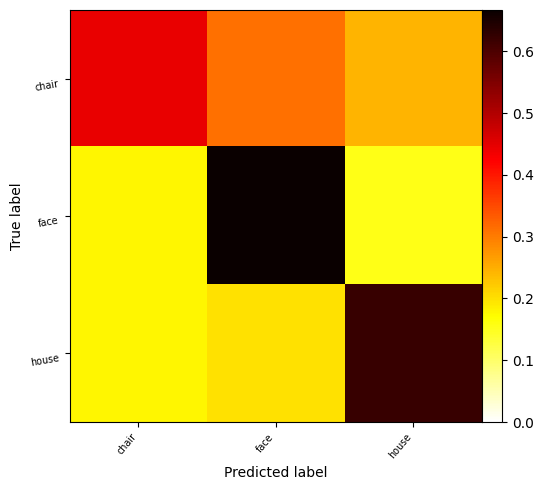

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix

from nilearn import plotting

# Calculate the confusion matrix
matrix = confusion_matrix(
    y_test,
    y_pred,
    normalize="true",
)

# Plot the confusion matrix
im = plotting.plot_matrix(
    matrix,
    labels=sorted(np.unique(y_test)),
    vmin=0,
    cmap="hot_r",
)

# Add x/y-axis labels
ax = im.axes
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Adjust figure to make labels fit
ax.get_figure().tight_layout()

plotting.show()

### Visualization of different model weights



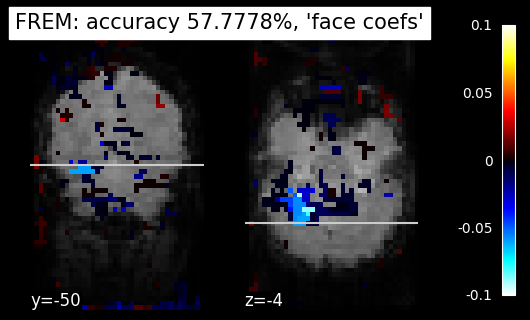

In [8]:
from nilearn import plotting

plotting.plot_stat_map(
    decoder.coef_img_['face'],
    background_img,
    title=f"FREM: accuracy {accuracy:g}%, 'face coefs'",
    cut_coords=(-50, -4),
    display_mode="yz",
)
plotting.show()

FREM ensembling procedure yields an important improvement of decoding
accuracy on this simple example compared to fitting only one model per
fold and the clustering mechanism keeps its computational cost reasonable
even on heavier examples. Here we ensembled several instances of l2-SVC,
but FREMClassifier also works with ridge or logistic.
FREMRegressor object is also available to solve regression problems.



## Use SpaceNet decoder

In [9]:
from nilearn.decoding import SpaceNetClassifier
# decoder = FREMClassifier(cv=10, standardize="zscore_sample")
decoder = SpaceNetClassifier(
                            penalty="graph-net",
                            cv=10,
                             standardize="zscore_sample")
# Fit model on train data and predict on test data
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.0
print(f"FREM classification accuracy : {accuracy:g}%")

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(40, 64, 64, 189),
affine=array([[  -3.5  ,    0.   ,    0.   ,   68.25 ],
       [   0.   ,    3.75 ,    0.   , -118.125],
       [   0.   ,    0.   ,    3.75 , -118.125],
       [   0.   ,    0.   ,    0.   ,    1.   ]])
)
[NiftiMasker.fit] Computing the mask
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 64, 64, 189),
affine=array([[  -3.5  ,    0.   ,    0.   ,   68.25 ],
       [   0.   ,    3.75 ,    0.   , -118.125],
       [   0.   ,    0.   ,    3.75 , -118.125],
       [   0.   ,    0.   ,    0.   ,    1.   ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/ext3/miniconda3/lib/python3.8/site-packages/nilearn/decoding/space_net.py:941: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile_ = _adjust_screening_percentile(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
........[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s
......................................................................................................................../ext3/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/ext3/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/ext3/miniconda3/lib/python3.8/site-packages/numpy/lib/fu

Time Elapsed: 527.6435348987579 seconds, 8.7940589149793 minutes.
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 64, 64, 135),
affine=array([[  -3.5  ,    0.   ,    0.   ,   68.25 ],
       [   0.   ,    3.75 ,    0.   , -118.125],
       [   0.   ,    0.   ,    3.75 , -118.125],
       [   0.   ,    0.   ,    0.   ,    1.   ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
FREM classification accuracy : 57.037%


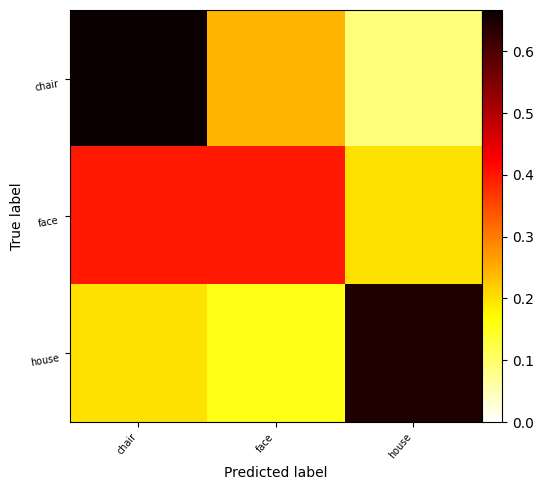

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix

from nilearn import plotting

# Calculate the confusion matrix
matrix = confusion_matrix(
    y_test,
    y_pred,
    normalize="true",
)

# Plot the confusion matrix
im = plotting.plot_matrix(
    matrix,
    labels=sorted(np.unique(y_test)),
    vmin=0,
    cmap="hot_r",
)

# Add x/y-axis labels
ax = im.axes
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Adjust figure to make labels fit
ax.get_figure().tight_layout()

plotting.show()

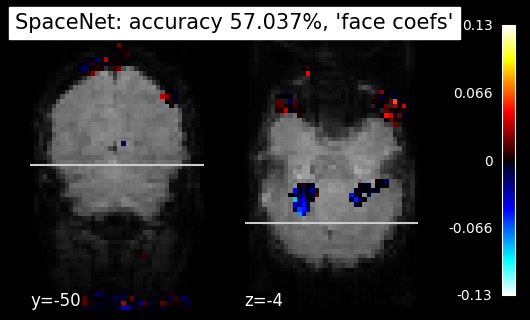

In [15]:
from nilearn import plotting

plotting.plot_stat_map(
    decoder.coef_img_.slicer[:, :, :, 1],
    background_img,
    title=f"SpaceNet: accuracy {accuracy:g}%, 'face coefs'",
    cut_coords=(-50, -4),
    display_mode="yz",
)
plotting.show()